# Part A

Start Simulation at 04:00:00 PM

ID: 2, Received emergency call at 04:12:31 PM
ID: 2, Dispatched an ambulance at 04:12:31 PM (delayed 0.00 min)
ID: 2, Ambulance arrived on emergency at 04:19:42 PM (distance:6.58km)
ID: 2, Finished loading a patient at 04:29:46 PM (loading time was 10.06 mins)
ID: 2, Arrived back on hospital at 04:36:56 PM
ID: 2, Started unloading a patient at 04:36:56 PM (delayed 0.00 min)
ID: 2, Finsihed unloading a patient at 04:41:56 PM; total time was 29.42.
 
ID: 1, Received emergency call at 04:09:33 PM
ID: 1, Dispatched an ambulance at 04:09:33 PM (delayed 0.00 min)
ID: 1, Ambulance arrived on emergency at 04:18:08 PM (distance:7.87km)
ID: 1, Finished loading a patient at 04:32:07 PM (loading time was 13.99 mins)
ID: 1, Arrived back on hospital at 04:40:43 PM
ID: 1, Started unloading a patient at 04:40:43 PM (delayed 0.00 min)
ID: 1, Finsihed unloading a patient at 04:45:43 PM; total time was 36.17.
 
ID: 5, Received emergency call at 04:24:35 PM
ID: 5, Dispatch

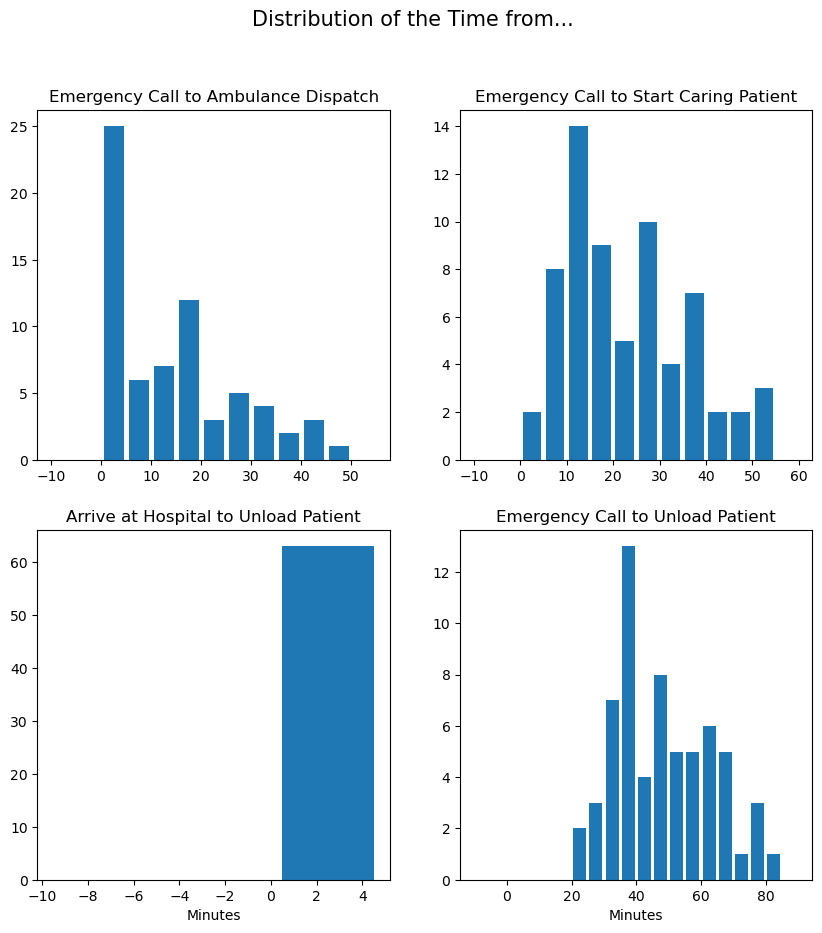

In [1]:
import random
import simpy
import numpy as np
import matplotlib.pyplot as plt
from datetime import *

# Define constants
DRIVE_SPEED = 55         # Car speed (km/h)
AVG_LOAD_PATIENTS = 11   # Mean time to load(care for) patients (mins) 
STD_LOAD_PATIENTS = 2.5  # Standard deviation to load patients (mins) 
UNLOAD_PATIENTS = 5      # Time to unload a patient from the ambulance

class AmbulanceSimA:

    def __init__(self):        
        # Define variables including the monitoring statistics
        self.clock = ""
        self.num_patients = 0           # Number of patients
        self.ambulance_operaiton = 0    # Total operation times of all ambulances
        self.time_call_to_dispatch = [] # Time from the emergency call to an ambulance becoming available
        self.time_call_to_care = []     # Time from the emergency call to the ambulance reaching the patient(=starting the care)
        self.time_back_to_unload = []   # Time from coming back to the ambulance to start unloading the patient (Wait time for bays)
        self.time_call_to_finish = []   # Time from the emergency call to the patient having been unloaded at the hospital
        
    def runsim(self, num_ambulances, emergency_rate, city_radius, num_bays):
        # initialize all variables here
        self.clock = datetime.strptime('04:00 PM', '%H:%M %p')        
        self.num_patients = 0
        self.ambulance_operaiton = 0 
        self.time_call_to_dispatch = []
        self.time_call_to_care = [] 
        self.time_back_to_unload = []
        self.time_call_to_finish = []

        print(f'Start Simulation at {self.clock:%H:%M:%S} PM\n')
        env = simpy.Environment()
        # Resource 'emergency' can be dealt with as long as the ambulances are available.
        # Resource is basically not available until the emergency is completed, which is being handled by an ambulance.
        emergency = simpy.Resource(env, capacity=num_ambulances)
        bay = simpy.Resource(env, capacity=num_bays)
        
        env.process(self.receive_call(env, emergency, bay, emergency_rate, city_radius))
        env.run(until=480) # run simulation for 8 hours (480 mins)
        
        # show the result of statistics
        print(" ")
        print("Time from the emergency call to an ambulance becoming available:")
        print(f"  Mean {np.mean(self.time_call_to_dispatch):.2f}, STD: {np.std(self.time_call_to_dispatch):.2f}")        
        print(" ")
        print("Time from the emergency call to the ambulance reaching the patient:")
        print(f"  Mean {np.mean(self.time_call_to_care):.2f}, STD: {np.std(self.time_call_to_care):.2f}")
        print(" ")
        print("Time waiting for a bay to unload the patient:")
        print(f"  Mean {np.mean(self.time_back_to_unload):.2f}, STD: {np.std(self.time_back_to_unload):.2f}")
        print(" ")
        print("Time from the emergency call to the patient having been unloaded at the hospital:")
        print(f"  Mean {np.mean(self.time_call_to_finish):.2f}, STD: {np.std(self.time_call_to_finish):.2f}")
        print(" ")
        
        print(f"Number of Patients: {self.num_patients}")
        activity_hours = (self.ambulance_operaiton/num_ambulances)/60
        utilization = (activity_hours/8)*100
        print(f"Avtivity Time per Ambulance: {activity_hours:.2f} Hours")        
        print(f"Total Costs: ${self.ambulance_operaiton/60*265:.2f}, (${activity_hours*265:.2f} per Ambulance)")
        print(f"Utilization per Ambulance: {utilization:.2f}%")
        percentile_90 = np.percentile(self.time_call_to_finish, 90)
        print(f"90% of patients wait less than {percentile_90:.2f} minutes from a single run.")


    def receive_call(self, env, emergency, bay, emergency_rate, city_radius):
        """
        Schedule the time to receive the emergency call
        This call is based on 'emergency_rate', which is the average minutes between emergencies
        """
        while True:
            # create emergency call
            yield env.timeout(random.expovariate(1/emergency_rate))
            receive_call_time = env.now
            self.num_patients += 1
            # start processing the ambulance dispatch 
            env.process(self.dispatch(self.num_patients, env, emergency, bay, city_radius, receive_call_time))
        
    def dispatch(self, ID, env, emergency, bay, city_radius, receive_call_time):
        # Dispatch Ambulances(resources) Immmidiately if They are Available
        with emergency.request() as emergency_req:
            yield emergency_req
            dispatch_time = env.now
            delay_emergency = dispatch_time - receive_call_time # diff-time between receiving call and dispatching ambulance.
            self.time_call_to_dispatch.append(delay_emergency)
            
            
            """
            Schedule the time to arrive at the emergency site.
            Considering that drivers drive at a constant speed of 55 km/h.
            """
            distance = city_radius * np.sqrt(random.random()) # calculate distance(km)
            driving = (distance / DRIVE_SPEED) * 60 # calculate the driving time (converted to minutes)
            yield env.timeout(driving)
            arrive_emergency_time = env.now
            self.time_call_to_care.append(arrive_emergency_time - receive_call_time)
            
            
            """
            Schedule the time to load a patient into the ambulance (start to end of caring/treatment)
            The loading time is based on the normal distribution (mean: 11 mins, std: 2.5 mins)
            """
            loading = float(np.random.normal(AVG_LOAD_PATIENTS, STD_LOAD_PATIENTS)) # normal distribution (mean=11, std=2.5)
            yield env.timeout(loading)
            finish_load_time = env.now
            
            
            """
            Schedule the time to arrive back at the hospital
            Suppose that ambulances take the same amount of time at which they came to pick up a patient.            
            """
            yield env.timeout(driving)
            arrive_hospital_time = env.now
            
            # Check Whether Any Bay(resource) is Available (wait them if fully using)
            with bay.request() as bay_req:
                yield bay_req
                
                """
                Schedule the time to unload the patient.
                Suppose that it takes 5 minutes on each time.
                """
                start_unload_time = env.now # start unloading once bays are available
                delay_unload = start_unload_time - arrive_hospital_time
                self.time_back_to_unload.append(delay_unload)                
                yield env.timeout(UNLOAD_PATIENTS) # time to unload a patient
                finish_unload_time = env.now
                        
            # record the total operation time of all ambulances
            total_time_from_dispatch = finish_unload_time - dispatch_time
            self.ambulance_operaiton += total_time_from_dispatch
            
            # record the total time to finish all duties
            total_time_from_call = finish_unload_time - receive_call_time
            self.time_call_to_finish.append(total_time_from_call)
            
            # print the results on each time
            print(f"ID: {ID}, Received emergency call at {self.clock+timedelta(minutes=receive_call_time):%H:%M:%S} PM")
            print(f"ID: {ID}, Dispatched an ambulance at {self.clock+timedelta(minutes=dispatch_time):%H:%M:%S} PM (delayed {delay_emergency:.2f} min)")
            print(f"ID: {ID}, Ambulance arrived on emergency at {self.clock+timedelta(minutes=arrive_emergency_time):%H:%M:%S} PM (distance:{distance:.2f}km)")
            print(f"ID: {ID}, Finished loading a patient at {self.clock+timedelta(minutes=finish_load_time):%H:%M:%S} PM (loading time was {loading:.2f} mins)")
            print(f"ID: {ID}, Arrived back on hospital at {self.clock+timedelta(minutes=arrive_hospital_time):%H:%M:%S} PM")
            print(f"ID: {ID}, Started unloading a patient at {self.clock+timedelta(minutes=start_unload_time):%H:%M:%S} PM (delayed {delay_unload:.2f} min)")
            print(f"ID: {ID}, Finsihed unloading a patient at {self.clock+timedelta(minutes=finish_unload_time):%H:%M:%S} PM; total time was {total_time_from_call:.2f}.")
            print(" ")

if __name__ == '__main__':
    simA = AmbulanceSimA()
    simA.runsim(num_ambulances=5, emergency_rate=7, city_radius=12, num_bays=3)
    
    # plot histograms
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    fig.suptitle('Distribution of the Time from...', fontsize=15)
    axs[0, 0].hist(simA.time_call_to_dispatch, rwidth=0.8, 
                   bins=[i for i in range(-10, int(max(simA.time_call_to_dispatch))+10, 5)])
    axs[0, 0].set_title("Emergency Call to Ambulance Dispatch")    
    axs[0, 1].hist(simA.time_call_to_care, rwidth=0.8, 
                   bins=[i for i in range(-10, int(max(simA.time_call_to_care))+10, 5)])
    axs[0, 1].set_title('Emergency Call to Start Caring Patient')    
    axs[1, 0].hist(simA.time_back_to_unload, rwidth=0.8, 
                   bins=[i for i in range(-10, int(max(simA.time_back_to_unload))+10, 5)])
    axs[1, 0].set_title('Arrive at Hospital to Unload Patient')
    axs[1, 0].set_xlabel('Minutes')
    axs[1, 1].hist(simA.time_call_to_finish, rwidth=0.8, 
                   bins=[i for i in range(-10, int(max(simA.time_call_to_finish))+10, 5)])
    axs[1, 1].set_title('Emergency Call to Unload Patient')    
    axs[1, 1].set_xlabel('Minutes')

# Part B

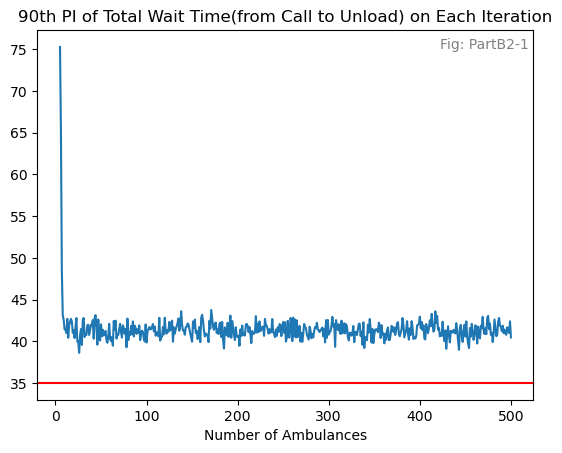

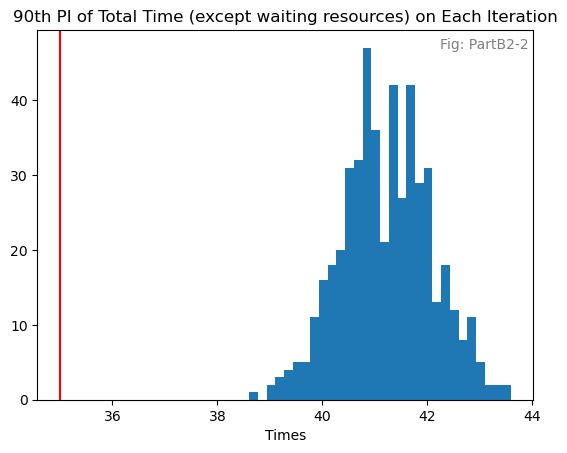

In [64]:
import random
import simpy
import numpy as np
import matplotlib.pyplot as plt
from datetime import *

# Define constants
DRIVE_SPEED = 55         # Car speed (km/h)
AVG_LOAD_PATIENTS = 11   # Mean time to load(care for) patients (mins) 
STD_LOAD_PATIENTS = 2.5  # Standard deviation to load patients (mins) 
UNLOAD_PATIENTS = 5      # Time to unload a patient from the ambulance

class AmbulanceSimB:

    def __init__(self):        
        # Define variables including the monitoring statistics
        self.clock = ""
        self.num_patients = 0           # Number of patients
        self.ambulance_operaiton = 0    # Total operation times of all ambulances
        self.time_call_to_dispatch = [] # Time from the emergency call to an ambulance becoming available
        self.time_call_to_care = []     # Time from the emergency call to the ambulance reaching the patient(=starting the care)
        self.time_back_to_unload = []   # Time from coming back to the ambulance to start unloading the patient (Wait time for bays)
        self.time_call_to_finish = []   # Time from the emergency call to the patient having been unloaded at the hospital
        
        self.driving_lst = [] # Driving time from  hospital to emergency site.
        self.loading_lst = [] # Loading time (including treatment).
        
    def runsim(self, num_ambulances, emergency_rate, city_radius, num_bays):
        # initialize all variables here
        self.clock = datetime.strptime('04:00 PM', '%H:%M %p')        
        self.num_patients = 0
        self.ambulance_operaiton = 0 
        self.time_call_to_dispatch = []
        self.time_call_to_care = [] 
        self.time_back_to_unload = []
        self.time_call_to_finish = []
        self.driving_lst = []
        self.loading_lst = []
        

        env = simpy.Environment()
        # Resource 'emergency' can be dealt with as long as the ambulances are available.
        # Resource is basically not available until the emergency is completed, which is being handled by an ambulance.
        emergency = simpy.Resource(env, capacity=num_ambulances)
        bay = simpy.Resource(env, capacity=num_bays)
        
        env.process(self.receive_call(env, emergency, bay, emergency_rate, city_radius))
        env.run(until=480) # run simulation for 8 hours (480 mins)
      

    def receive_call(self, env, emergency, bay, emergency_rate, city_radius):
        """
        Schedule the time to receive the emergency call
        This call is based on 'emergency_rate', which is the average minutes between emergencies
        """
        while True:
            yield env.timeout(random.expovariate(1/emergency_rate))
            receive_call_time = env.now
            self.num_patients += 1
            # start processing the ambulance dispatch 
            env.process(self.dispatch(self.num_patients, env, emergency, bay, city_radius, receive_call_time))
        
    def dispatch(self, ID, env, emergency, bay, city_radius, receive_call_time):
        # Dispatch Ambulances(resources) Immmidiately if They are Available
        with emergency.request() as emergency_req:
            yield emergency_req
            dispatch_time = env.now
            delay_emergency = dispatch_time - receive_call_time # diff-time between receiving call and dispatching ambulance.
            self.time_call_to_dispatch.append(delay_emergency)
            
            
            """
            Schedule the time to arrive at the emergency site.
            Considering that drivers drive at a constant speed of 55 km/h.
            """
            distance = city_radius * np.sqrt(random.random()) # calculate distance(km)
            driving = (distance / DRIVE_SPEED) * 60 # calculate the driving time (converted to minutes)            
            yield env.timeout(driving)
            arrive_emergency_time = env.now
            self.time_call_to_care.append(arrive_emergency_time - receive_call_time)
            
            
            """
            Schedule the time to care for a patient
            The treatment time is based on the normal distribution (mean: 11 mins, std: 2.5 mins)
            """
            loading = float(np.random.normal(AVG_LOAD_PATIENTS, STD_LOAD_PATIENTS)) # normal distribution (mean=11, std=2.5)
            yield env.timeout(loading)
            finish_load_time = env.now
            
            
            """
            Schedule the time to arrive back at the hospital
            Suppose that ambulances take the same amount of time at which they came to pick up a patient.            
            """
            yield env.timeout(driving)
            arrive_hospital_time = env.now
            
            # Start Unloading a Patient if Any Bay(recource) is Available
            with bay.request() as bay_req:
                yield bay_req
                
                """
                Schedule the time to unload the patient.
                Suppose that it takes 5 minutes on each time.
                """
                start_unload_time = env.now # start unloading once bays are available
                delay_unload = start_unload_time - arrive_hospital_time
                self.time_back_to_unload.append(delay_unload)                
                yield env.timeout(UNLOAD_PATIENTS) # time to unload a patient
                finish_unload_time = env.now
                        
            # record the total operation time of all ambulances
            total_time_from_dispatch = finish_unload_time - dispatch_time
            self.ambulance_operaiton += total_time_from_dispatch
            
            # record the total time to finish all duties
            total_time_from_call = finish_unload_time - receive_call_time
            self.time_call_to_finish.append(total_time_from_call)
            
            # track variables for QuestionB
            self.driving_lst.append(driving)
            self.loading_lst.append(loading)

if __name__ == '__main__':   
    # Repeat processes until the number of ambulances becomes 500.
    # Class 'AmbulanceSimB' is the same system as 'AmbulanceSimA' but removes all print methods.    
    ambulances = 5
    lst_num_ambulances = []
    lst_percentile_90 = []
    lst_90PI_total_time_except_waiting_resource = []

    while ambulances <= 500:    
        lst_num_ambulances.append(ambulances)
        simB = AmbulanceSimB()
        simB.runsim(ambulances, 7, 12, 3)
        calculate = np.percentile([simB.driving_lst[i]*2 + simB.loading_lst[i] + 5 for i in range(len(simB.driving_lst))], 90)
        # the list below is the total time excluding the time of waiting resources (ambulances & bays)
        # calculatioin: driving time(both head & back) + loading time + fixed unloading time (5 mins)
        lst_90PI_total_time_except_waiting_resource.append(calculate)
        percentile_90 = np.percentile(simB.time_call_to_finish, 90)
        lst_percentile_90.append(percentile_90)
        ambulances += 1

    plt.figure(1)    
    plt.plot(lst_num_ambulances, lst_percentile_90)
    plt.title("90th PI of Total Wait Time(from Call to Unload) on Each Iteration")
    plt.xlabel('Number of Ambulances')
    plt.text(x=0.99, y=0.95, s='Fig: PartB2-1', color='grey', ha='right', transform=plt.gca().transAxes)
    plt.axhline(y = 35, color = 'r', linestyle = '-')
    
    plt.figure(2)
    plt.hist(lst_90PI_total_time_except_waiting_resource, bins=30)
    plt.title("90th PI of Total Time (except waiting resources) on Each Iteration")
    plt.xlabel('Times')
    plt.text(x=0.99, y=0.95, s='Fig: PartB2-2', color='grey', ha='right', transform=plt.gca().transAxes)
    plt.axvline(x = 35, color = 'r', linestyle = '-')

# Save Figure

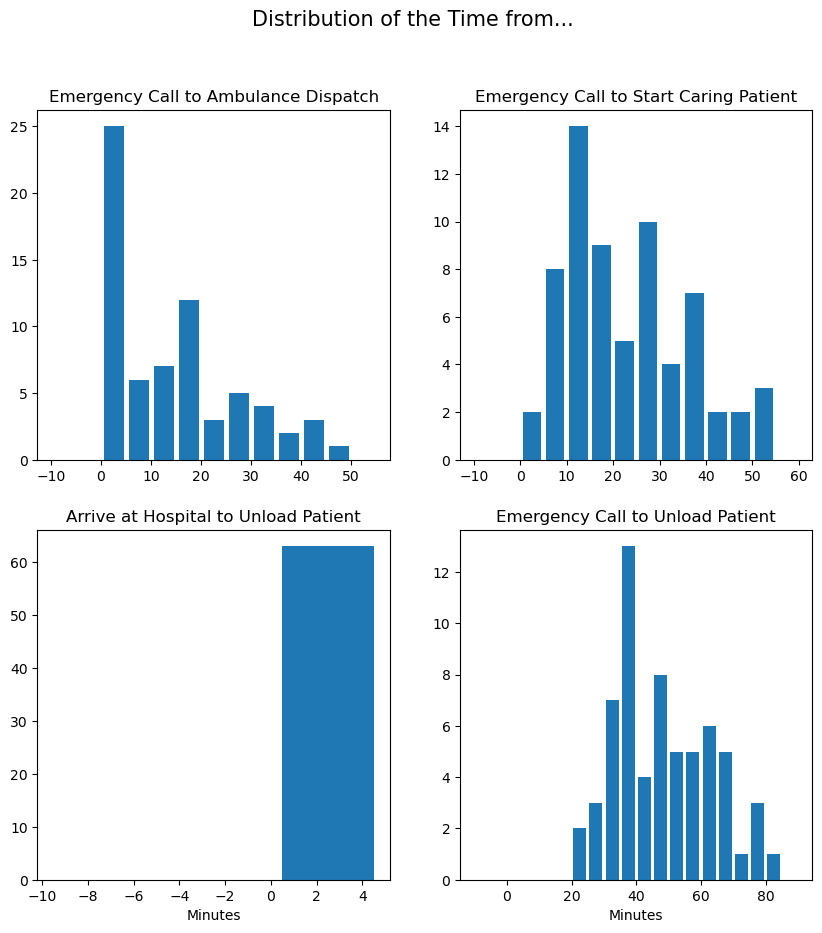

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Distribution of the Time from...', fontsize=15)
axs[0, 0].hist(simA.time_call_to_dispatch, rwidth=0.8, 
               bins=[i for i in range(-10, int(max(simA.time_call_to_dispatch))+10, 5)])
axs[0, 0].set_title("Emergency Call to Ambulance Dispatch")    
axs[0, 1].hist(simA.time_call_to_care, rwidth=0.8, 
               bins=[i for i in range(-10, int(max(simA.time_call_to_care))+10, 5)])
axs[0, 1].set_title('Emergency Call to Start Caring Patient')    
axs[1, 0].hist(simA.time_back_to_unload, rwidth=0.8, 
               bins=[i for i in range(-10, int(max(simA.time_back_to_unload))+10, 5)])
axs[1, 0].set_title('Arrive at Hospital to Unload Patient')
axs[1, 0].set_xlabel('Minutes')
axs[1, 1].hist(simA.time_call_to_finish, rwidth=0.8, 
               bins=[i for i in range(-10, int(max(simA.time_call_to_finish))+10, 5)])
axs[1, 1].set_title('Emergency Call to Unload Patient')    
axs[1, 1].set_xlabel('Minutes')

plt.savefig('PartA.png')

In [5]:
# Part B - 1

"""
Get the 90th percentile total wait time (from emergency call to unloading patient).
Based on following parameters; num_ambulances=5, emergency_rate=7, city_radius=12, num_bays=3
"""

percentile_90 = np.percentile(simA.time_call_to_finish, 90)
print(f"90% of patients wait less than {percentile_90:.2f} minutes from a single run.")

90% of patients wait less than 91.66 minutes from a single run.


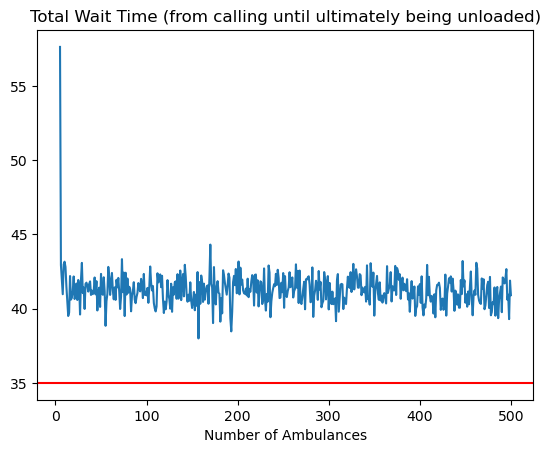

In [52]:
plt.plot(lst_num_ambulances, lst_percentile_90)
plt.title("Total Wait Time (from calling until ultimately being unloaded)")
plt.xlabel('Number of Ambulances')
plt.axhline(y = 35, color = 'r', linestyle = '-')
plt.savefig('PartB2-1.png')

'\nThis graph shows the 90th percentile of total time from dispatching ambulances and arriving back at hospital on each simulation.\nIt means that the following wait times are excluded; the time between receiving call and dispatching ambulances and the time between arriving back and begining to \n'

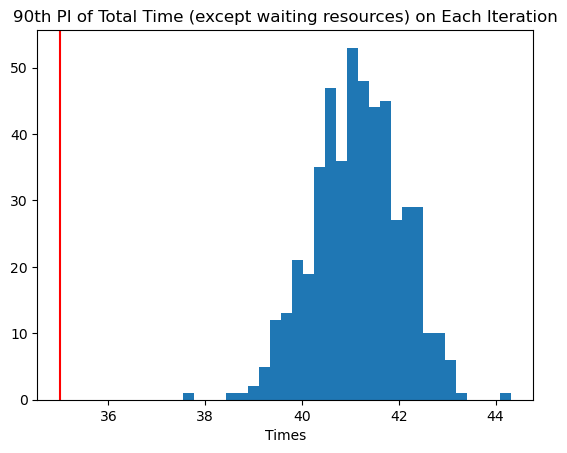

In [54]:
plt.hist(lst_90PI_total_time_except_waiting_resource, bins=30)
plt.title("90th PI of Total Time (except waiting resources) on Each Iteration")
plt.xlabel('Times')
plt.axvline(x = 35, color = 'r', linestyle = '-')
plt.savefig('PartB2-2.png')

"""
This graph shows the 90th percentile of total time excluding the wait time for resources (ambulances and bays) on each simulation.
The outcome shows that 90% of patients need to wait for around 38-44 mins regardless of the number of ambulances and bays.
In other words, no matter how we increase resources, we cannot reach the level which is mentioned in question B; 
 the number of ambulances required to get a 90th percentile time of 35 minutes or less.
"""

This graph shows the 90th percentile of total time excluding the wait time for resources (ambulances and bays) on each simulation.
The outcome shows that 90% of patients need to wait for around 38-44 mins regardless of the number of ambulances and bays.
In other words, no matter how we increase resources, we cannot reach the level which is mentioned in question B; 
 the number of ambulances required to get a 90th percentile time of 35 minutes or less.